# Reading and Exploring the Data

In [23]:
'''
Author: Sriram Yarlagadda
Date Created: 8/26/2016
Note: Please use Python 2.7
'''
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#os.chdir('C:\Users\syarlag1\Desktop\Loyola-SAH-Analysis') #Set location of home dir here.
os.chdir('/Users/Sriram/Desktop/DePaul/Loyola-SAH-Analysis')#location in Mac

### Reading Data

In [2]:
os.chdir('./data')
dataFiles = os.listdir('.')
varLst = ['KEY','LOS','DIED','AGE','SAH','ASA','PT_INT_SAH','PT_INT_SAH_ASA','SCORE']#Names of the variables we need
fullDataDict = {}
for fileName in dataFiles:
    dataStr = fileName[:2] + 'Data'; print dataStr #print to confirm that the data is created
    fullDataDict[dataStr] = pd.DataFrame()
    fullDataDict[dataStr] = pd.read_stata(fileName, columns=varLst)
    fullDataDict[dataStr]['KEY'] = fullDataDict[dataStr]['KEY'].astype(str)#Setting the KEY variable as an object   
    #fullDataDict[dataStr].index = fullDataDict[dataStr]['KEY']; del fullDataDict[dataStr]['KEY'] #Setting 'KEY' as index

CAData
FLData
IAData
NYData
WAData


In [3]:
for key in fullDataDict.keys(): #creating a new state identifier column
    fullDataDict[key]['State'] = pd.Series([str(key)[:2]]*fullDataDict[key].shape[0])
allStateData = pd.concat(fullDataDict.values()) #combing into a single dataframe
allStateData.index = range(allStateData.shape[0])

### Data Preprocessing

In [4]:
allStateData.describe()

,LOS,DIED,AGE,SAH,ASA,PT_INT_SAH,PT_INT_SAH_ASA,SCORE
count,38307.000000,38304.000000,38231.000000,38310.0,38310.000000,38310.0,38310.000000,38310.000000
mean,12.153001,0.204626,58.659569,1.0,0.033908,1.0,0.033908,5.732522
std,37.072215,0.406335,16.465707,0.0,0.180971,0.0,0.180971,10.280618
min,-6666.000000,-9.000000,0.000000,1.0,0.000000,1.0,0.000000,0.298197
25%,3.000000,0.000000,48.000000,1.0,0.000000,1.0,0.000000,0.932394
50%,9.000000,0.000000,58.000000,1.0,0.000000,1.0,0.000000,0.932394
75%,17.000000,0.000000,71.000000,1.0,0.000000,1.0,0.000000,6.958751
max,362.000000,1.000000,111.000000,1.0,1.000000,1.0,1.000000,106.059479


As we can see if have some abberations. For example, the min of LOS is -6666, which is not possible. Hence we quickly scan for other such outliers and remove the corresponding cases.

In [5]:
np.sum(np.array(allStateData < 0), 0)

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

As we can see from the above output, only two features -- LOS and DIED -- have negative values. We look at the cases that correspond to these:

In [6]:
allStateData[allStateData['DIED'] < 0]

,KEY,LOS,DIED,AGE,SAH,ASA,PT_INT_SAH,PT_INT_SAH_ASA,SCORE,State
35184,6.20061320052e+12,1.0,-9.0,46.0,1.0,0.0,1.0,0.0,6.958751,CA


In [7]:
allStateData[allStateData['LOS'] < 0]

,KEY,LOS,DIED,AGE,SAH,ASA,PT_INT_SAH,PT_INT_SAH_ASA,SCORE,State
24598,6.20061082797e+12,-6666.0,0.0,67.0,1.0,0.0,1.0,0.0,5.473947,CA


In [8]:
np.sum(np.array(pd.isnull(allStateData)),0)

array([ 0,  3,  6, 79,  0,  0,  0,  0,  0,  0])

There are **89** missing values in our data.

We remove all cases which have such outliers:

In [9]:
for feature in allStateData.columns: 
    allStateData = allStateData[allStateData[feature] >= 0] #removing all the cases that are less than 0 (only 2 in our case)

In [10]:
os.chdir('./..')
allStateData.to_csv('./allStateData.csv')

### Data Exploration

In [9]:
allStateData = pd.read_csv('./allStateData.csv')#ignore this if running script from top

Taking a look at the number of cases by state:

In [19]:
allStateData.State.value_counts()

CA    18357
FL     8602
NY     8318
WA     2006
IA      937
Name: State, dtype: int64

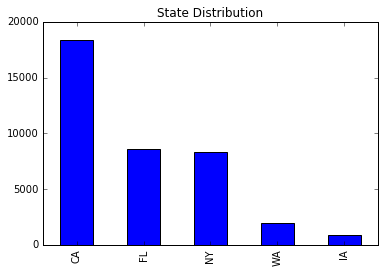

In [28]:
allStateData.State.value_counts().plot('bar')
plt.title('State Distribution')

As seen above, California has the most number of cases, more than the next two (FL and NY) combined.


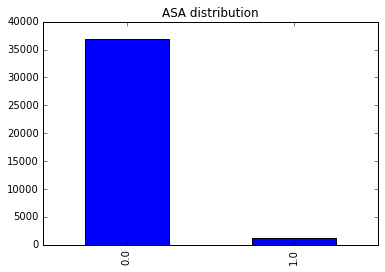

In [27]:
allStateData.ASA.value_counts().plot('bar')
plt.title('ASA distribution')

The above barplot shows us that there are **far fewer** cases of ASA than without ASA

Next we visualize the relation between the Length of Stay (LOS), Died, Age, and High Asprin use and SAH presence (ASA).

First we look at the distribution of the "score" variable:

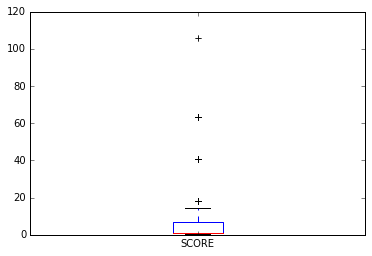

In [59]:
###ASA = 0
allStateData[allStateData.ASA == 0.].SCORE.plot('box')

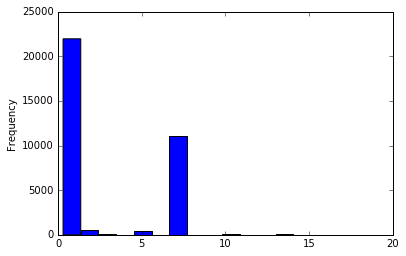

In [61]:
#Hist of the ASA spread on the LOS variable
allStateData[allStateData.ASA == 0.].SCORE.plot('hist', xlim=(0,20), bins = 100) #zooming in to ignore outliers

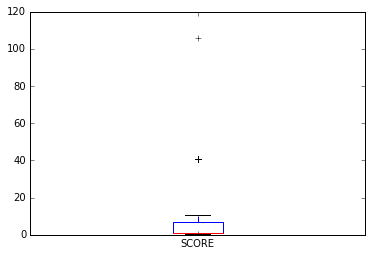

In [62]:
##ASA == 1
allStateData[allStateData.ASA == 1.].SCORE.plot('box')

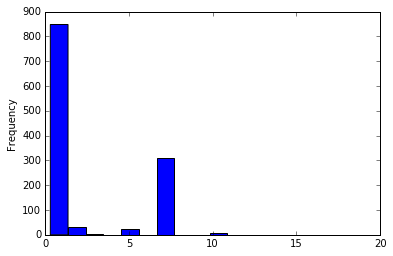

In [63]:
allStateData[allStateData.ASA == 1.].SCORE.plot('hist', xlim=(0,20), bins = 100) #zooming in to ignore outliers

From above we can see that both ASA = 1 and ASA = 0 both have a similar distribution for the SCORE variable. However, it is important to notice that these distributions are **NOT** normal. T-tests may not be appropriate when the distributions are not normal.

In [65]:
allStateData[allStateData.ASA == 0.].SCORE.value_counts()

0.932394      21366
6.958751      11082
40.853809      2631
0.298197        575
5.473947        422
1.447735        297
2.225541        236
10.804901       129
13.065824        59
2.420563         43
63.434006        30
18.065428        23
8.499436          8
0.463013          8
1.750672          4
0.774142          3
106.059479        3
3.455614          1
1.558931          1
14.210769         1
Name: SCORE, dtype: int64

In [66]:
allStateData[allStateData.ASA == 0.].SCORE.value_counts()

0.932394      21366
6.958751      11082
40.853809      2631
0.298197        575
5.473947        422
1.447735        297
2.225541        236
10.804901       129
13.065824        59
2.420563         43
63.434006        30
18.065428        23
8.499436          8
0.463013          8
1.750672          4
0.774142          3
106.059479        3
3.455614          1
1.558931          1
14.210769         1
Name: SCORE, dtype: int64

In [70]:
allStateData[allStateData.ASA == 1.].LOS.mean()

8.312788906009246

In [71]:
allStateData[allStateData.ASA == 0.].LOS.mean() 

12.484453713233302

In [91]:
allStateData[allStateData.ASA == 1.].SCORE.mean()

4.9821646668603625

In [92]:
allStateData[allStateData.ASA == 0.].SCORE.mean()

5.768029964112174

### Mann–Whitney U tests

Mann-Whitney test is preferred over a t-test since the data is very unbalanced and it is not normal

In [72]:
from scipy import stats  

#### Q1 Is there a relation between Aspring Usage (ASA) and Hospital Stay (LOS)?

To answer this question, we run a simple Mann-Whitney test on both the groups

In [83]:
group1_LOS =  allStateData[allStateData.ASA == 0.].LOS
group2_LOS =  allStateData[allStateData.ASA == 1.].LOS

In [86]:
z_stat, p_val = stats.mannwhitneyu(group1_LOS, group2_LOS, alternative = 'greater')  
print "MWW RankSum P for groups 1 and 2 =", p_val  

MWW RankSum P for groups 1 and 2 = 3.00882055468e-30


Since the p-value is <0.01, there is enough evidence to prove that the mean Hospital length of stay between patients that **use** asprin is **greater** than those that don't

#### Q2 Is there a relation between Aspring Usage (ASA) and Mortality (DIED)?

In [88]:
group1_DIED =  allStateData[allStateData.ASA == 0.].DIED
group2_DIED =  allStateData[allStateData.ASA == 1.].DIED

In [89]:
z_stat, p_val = stats.mannwhitneyu(group1_DIED, group2_DIED, alternative='greater')  
print "MWW RankSum P for groups 1 and 2 =", p_val  

MWW RankSum P for groups 1 and 2 = 0.397266478553


Since the p-value is >0.05, there is **not** enough evidence to prove that there is a difference in the mortality rate between patients that use asprine and those that dont

#### Q3 Is there a relation between Aspring Usage (ASA) and Severity of SAH (SCORE)?

In [80]:
group1_SCORE =  allStateData[allStateData.ASA == 0.].SCORE
group2_SCORE =  allStateData[allStateData.ASA == 1.].SCORE

In [94]:
z_stat, p_val = stats.mannwhitneyu(group1_SCORE, group2_SCORE, alternative = 'greater')  
print "MWW RankSum P for groups 1 and 2 =", p_val  

MWW RankSum P for groups 1 and 2 = 4.90990106523e-05


Since the p-value is <0.01, there is enough evidence to prove that the severity of SAH of patients that use asprin is greater than those that don't